# Process DCIS Data for svgs

23JAN24

In [1]:
# figdir = "/home/ckmah/d/bento-manuscript/notebooks/figure-analysis/figures"
figdir = "/home/ckmah/d/bento-manuscript/figures/breast_cancer_supp"

In [18]:
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import bento as bt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [3]:
# data directory
adata = bt.io.read_h5ad("dcis1_crop_flux.h5ad")
adata

AnnData object with n_obs × n_vars = 406 × 541
    obs: 'cell_shape', 'nucleus_shape', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden_res1.0', 'cell_type', 'cell_area', 'cell_aspect_ratio', 'cell_density', 'nucleus_area', 'nucleus_aspect_ratio', 'nucleus_density', 'cell_radius', 'nucleus_radius'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cell_raster', 'cell_type_colors', 'dendrogram_cell_type', 'flux', 'flux_counts', 'flux_embed', 'flux_genes', 'flux_n_components', 'flux_sv', 'flux_variance_ratio', 'leiden', 'leiden_res1.0_colors', 'log1p', 'neighbors', 'pca', 'point_sets', 'points', 'rank_genes_groups', 'umap', 'wilcoxon'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts

In [4]:
valid_genes = ~(
    adata.var_names.str.startswith("BLANK")
    | adata.var_names.str.startswith("NegControl")
)
adata = adata[:, valid_genes]
bt.sync(adata)

In [5]:
flux_params = dict(res=1, alpha=True, dx=0.2125)

# RNAflux

In [6]:
def rnaFlux(adata, res=1):
    if "cell_raster" in adata.uns_keys():
        del adata.uns["cell_raster"]
    if "cell_raster" in adata.obs_keys():
        del adata.obs["cell_raster"]
    if "cell_raster" in adata.uns["point_sets"]:
        del adata.uns["point_sets"]["cell_raster"]
    # mean_radius = adata.obs["cell_radius"].mean()
    bt.tl.flux(adata, res=res, n_components=10, train_size=1)

In [7]:
rnaFlux(adata)

  0%|          | 0/406 [00:00<?, ?it/s]

Saved to /home/ckmah/d/bento-manuscript/figures/breast_cancer_supp/dcis1_rnaflux.svg


Text(0.5, 1.0, 'DCIS1 RNA Flux')

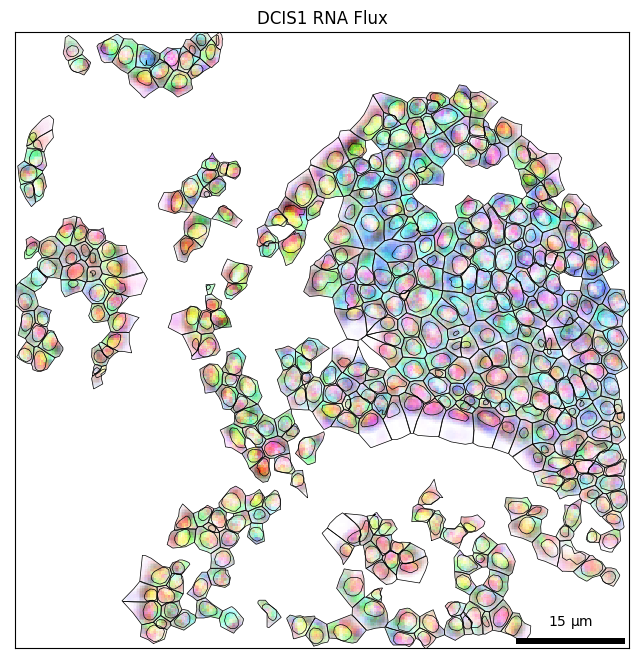

In [8]:
plt.figure(figsize=(8, 8))
bt.pl.flux(
    adata,
    **flux_params,
    fname=f"{figdir}/dcis1_rnaflux.svg",
)
plt.title("DCIS1 RNA Flux")

# Fluxmap

In [9]:
res = 1
bt.tl.fluxmap(adata, res=res, n_clusters=3, min_points=0)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/406 [00:00<?, ?it/s]

  0%|          | 0/406 [00:00<?, ?it/s]

Saved to /home/ckmah/d/bento-manuscript/figures/breast_cancer_supp/dcis1_fluxmap.svg


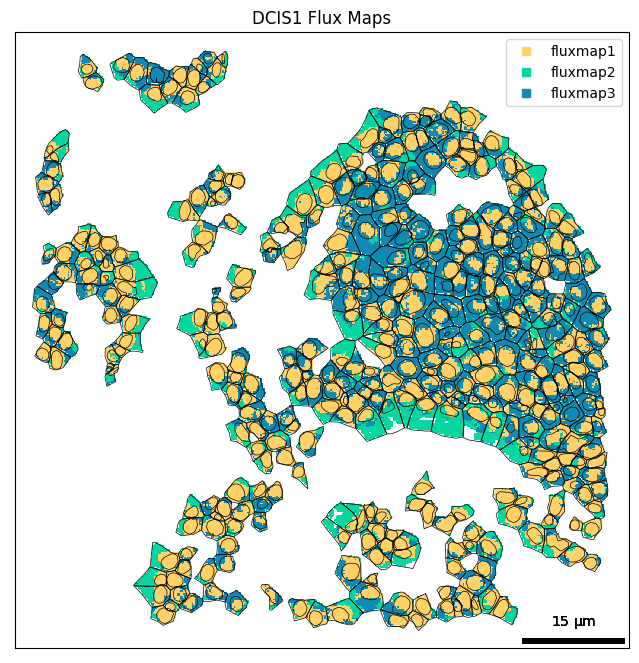

In [11]:
plt.figure(figsize=(8, 8))
bt.pl.fluxmap(
    adata,
    title="DCIS1 Flux Maps",
    palette=sns.color_palette(bt.colors.bento6, n_colors=3),
    lw=0,
    dx=0.2125,
    fname=f"{figdir}/dcis1_fluxmap.svg",
)

### Functional enrichment of fluxmaps

Apex seq data comparison

In [12]:
adata.uns["point_sets"]["cell_raster"] = list(adata.uns["point_sets"]["cell_raster"])

In [13]:
bt.tl.fe_xia2019(adata)

255 samples of mat are empty, they will be removed.
Running wsum on mat with 64190 samples and 317 targets for 2 sources.
Infering activities on 7 batches.


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


In [14]:
adata.uns["fe_ngenes"]

source,ER,Nucleus
n_genes,11903,11903


In [15]:
adata.uns["fe_stats"]

,ER,Nucleus
cell,,
10042,133,133
10043,133,133
10044,133,133
10045,133,133
10046,133,133
...,...,...
130416,133,133
130417,133,133
130421,133,133


Saved to /home/ckmah/d/bento-manuscript/figures/breast_cancer_supp/dcis1_domain_fe.svg


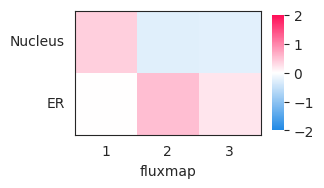

In [25]:
@bt.pl._utils.savefig
def plot_domain_fe(data, fname=None):
    domains = [
        "flux_Nucleus",
        "flux_ER",
    ]

    domain_fe = pd.DataFrame(
        np.stack([data.uns[d] for d in domains], axis=1),
        index=data.uns["cell_raster"].index,
        columns=domains,
    )
    domain_fe.dropna(inplace=True)
    domain_fe = domain_fe.groupby(data.uns["cell_raster"]["fluxmap"]).mean()
    domain_fe.columns = [d.split("flux_")[1] for d in domain_fe.columns]

    # domain_fe = domain_fe.iloc[1:]

    with sns.axes_style("white"):
        fig = plt.figure(figsize=(3, 3))
        ax = sns.heatmap(
            domain_fe.T,
            center=0,
            vmin=-2,
            vmax=2,
            cmap=bt.colors.red2blue,
            square=True,
            cbar_kws=dict(shrink=0.5, aspect=10),
            # figsize=(3, 2),
        )
        ax.spines[:].set_visible(True)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


plot_domain_fe(adata, fname=f"{figdir}/dcis1_domain_fe.svg")

In [16]:
domain_palette = {
    "fluxmap1": sns.desaturate("#ef476f", 0.85),
    "fluxmap2": sns.desaturate("#FFD166", 0.85),
    "fluxmap0": sns.desaturate("#118AB2", 0.85),
    "fluxmap3": sns.desaturate("#06D6A0", 0.85),
}


dx = 0.2

Saved to /home/ckmah/d/bento-manuscript/figures/breast_cancer_supp/dcis1_fe_domains.svg


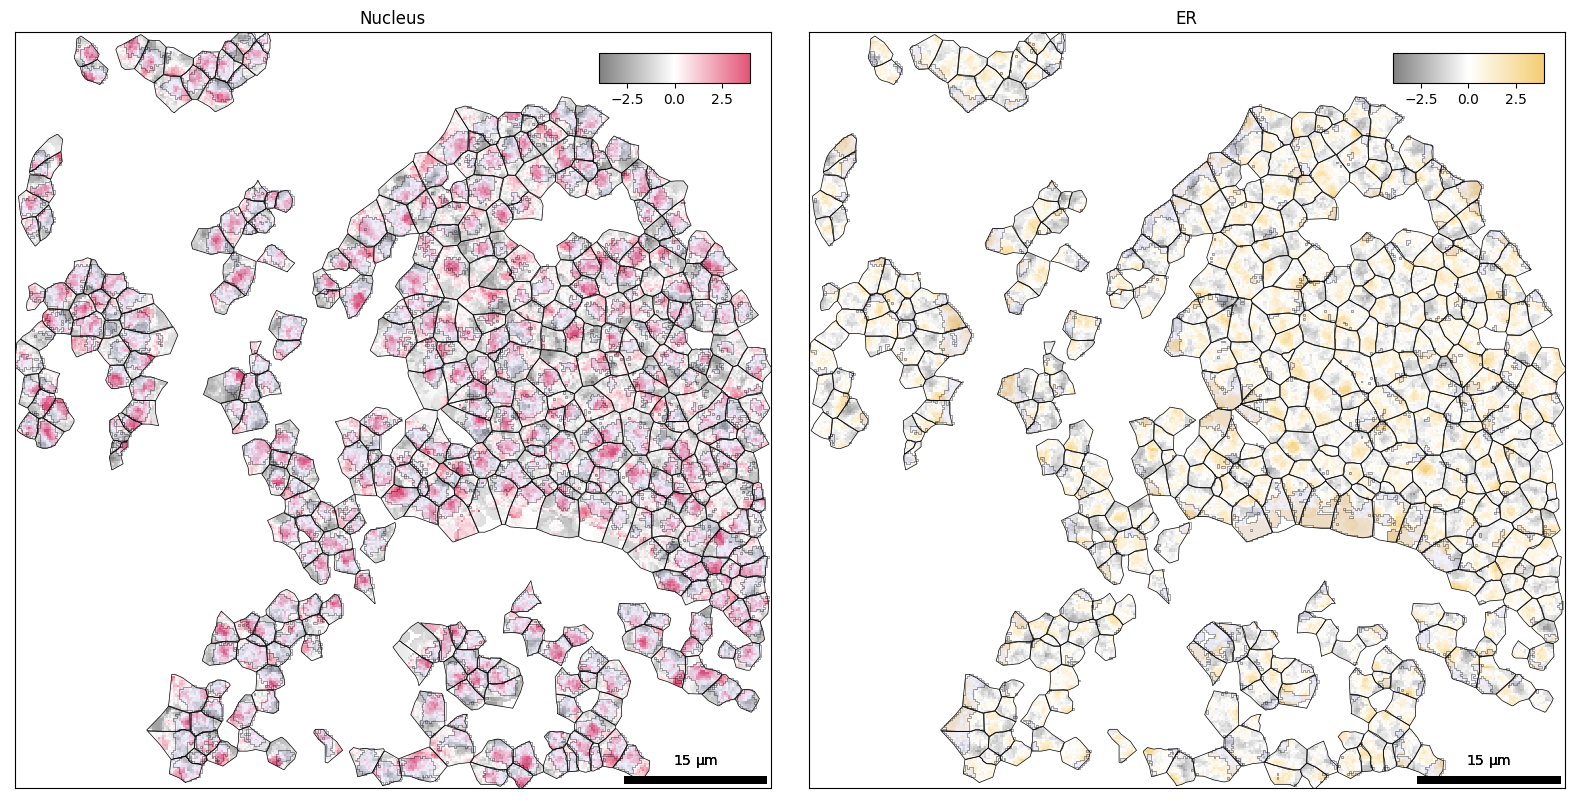

In [23]:
@bt.pl._utils.savefig
def plot_flux_fe(data, fname=None):
    domains = ["flux_Nucleus", "flux_ER"]

    domain_fe = pd.DataFrame(
        np.stack([data.uns[d] for d in domains], axis=1),
        index=data.uns["cell_raster"].index,
        columns=domains,
    )

    domain_fe = domain_fe.groupby(data.uns["cell_raster"]["fluxmap"]).mean()
    domain_fe = domain_fe.iloc[1:, :]
    fluxmap2domain = domain_fe.idxmax(axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    for shape, color, ax in zip(fluxmap2domain.index, bt.colors.bento6, axes.flat):
        cmap = mpl.colors.LinearSegmentedColormap.from_list(
            "_",
            ["gray", "white", domain_palette[f"fluxmap{shape}"]],  # nuc read er yellow
        )
        domain = fluxmap2domain[shape]
        bt.pl.shapes(
            adata,
            shapes=f"fluxmap{shape}",
            facecolor="blue",
            alpha=0.05,
            lw=0.5,
            ax=ax,
            dx=dx,
        )
        bt.pl.shapes(
            adata,
            shapes=f"fluxmap{shape}",
            alpha=0.5,
            lw=0.5,
            ax=ax,
            dx=dx,
        )
        bt.pl.fe(
            adata,
            domain,
            res=1,
            cmap=cmap,
            ax=ax,
            title=domain.split("_")[1],
            shapes=["cell_shape"],
            square=True,
            vmin=-4,
            vmax=4,
            dx=dx,
        )

    # remove empty axes
    for ax in axes.flat[domain_fe.shape[0] :]:
        ax.remove()
    plt.subplots_adjust(wspace=0.05, hspace=0.1)


plot_flux_fe(adata, fname=f"{figdir}/dcis1_fe_domains.svg")